# AuNR DA Figure S5

In [7]:
import sys
# add path for my packages
sys.path.append('./datasets')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

%precision 3
%matplotlib inline

# use my matplotlib style
plt.style.use('./datasets/my_rc_setting.mplstyle')

## input data

In [8]:
glass_data = pd.read_csv('./datasets/090723_glass_training.csv')
glass_data = glass_data.drop(['R2'], axis=1)
original_data = pd.read_csv('./datasets/New_SPP.csv')
combined_data = pd.concat([glass_data, original_data], axis=0)
combined_data['volume'] = np.pi*(combined_data['width']**2)*combined_data['length']/4 - np.pi*(combined_data['width']**3)/12
combined_data['ratio'] = combined_data['length'] / combined_data['width']
combined_data = combined_data[(combined_data['width'] < 60) & (combined_data['length'] < 130)]
combined_data = combined_data.reset_index(drop=True)
print(combined_data.shape)

(1701, 7)


In [9]:
exp_glass_data = pd.read_csv('./datasets/121124_test_data.csv')
X_exp_glass = exp_glass_data.drop(['Exp_width', 'Exp_length', 'Sim_eres', 'Sim_lw', 'Sim_width', 'Sim_length',
                                   'Exp_ratio', 'Sim_ratio', 'dif_eres', 'dif_lw', 'dif_width', 'dif_length', 'dif_ratio'], axis=1)
yw_exp_glass = exp_glass_data['Exp_width']
yl_exp_glass = exp_glass_data['Exp_length']
X_exp_glass = X_exp_glass.rename(columns={"Exp_eres": "eres", "Exp_lw": "linewidth"})
print(X_exp_glass.shape)

(64, 2)


## model training

In [10]:
X_glass = combined_data.drop(['width', 'length', 'imax', 'ratio', 'volume'], axis=1)
yw_glass = combined_data['width']
yl_glass = combined_data['length']
print(X_glass.shape)

(1701, 2)


In [11]:
# parameters for GridSearchCV class
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 5]
}

# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

gsw.fit(X_glass, yw_glass)

wmodel = DecisionTreeRegressor(max_depth=gsw.best_params_['max_depth'],
                               min_samples_split=gsw.best_params_['min_samples_split'],
                               min_samples_leaf=gsw.best_params_['min_samples_leaf'])

# fitting
wmodel.fit(X_glass, yw_glass)
yw_pred0 = wmodel.predict(X_exp_glass)
maew0 = mean_absolute_error(yw_exp_glass, yw_pred0)

# Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=5, scoring="neg_mean_squared_error")

gsl.fit(X_glass, yl_glass)

lmodel = DecisionTreeRegressor(max_depth=gsl.best_params_['max_depth'],
                               min_samples_split=gsl.best_params_['min_samples_split'],
                               min_samples_leaf=gsl.best_params_['min_samples_leaf'])

# fitting
lmodel.fit(X_glass, yl_glass)
yl_pred0 = gsl.predict(X_exp_glass)
mael0 = mean_absolute_error(yl_exp_glass, yl_pred0)

print(maew0, mael0)

2.25672129052428 7.630667593106818


C:\Users\katsuya2\AppData\Local\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
C:\Users\katsuya2\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


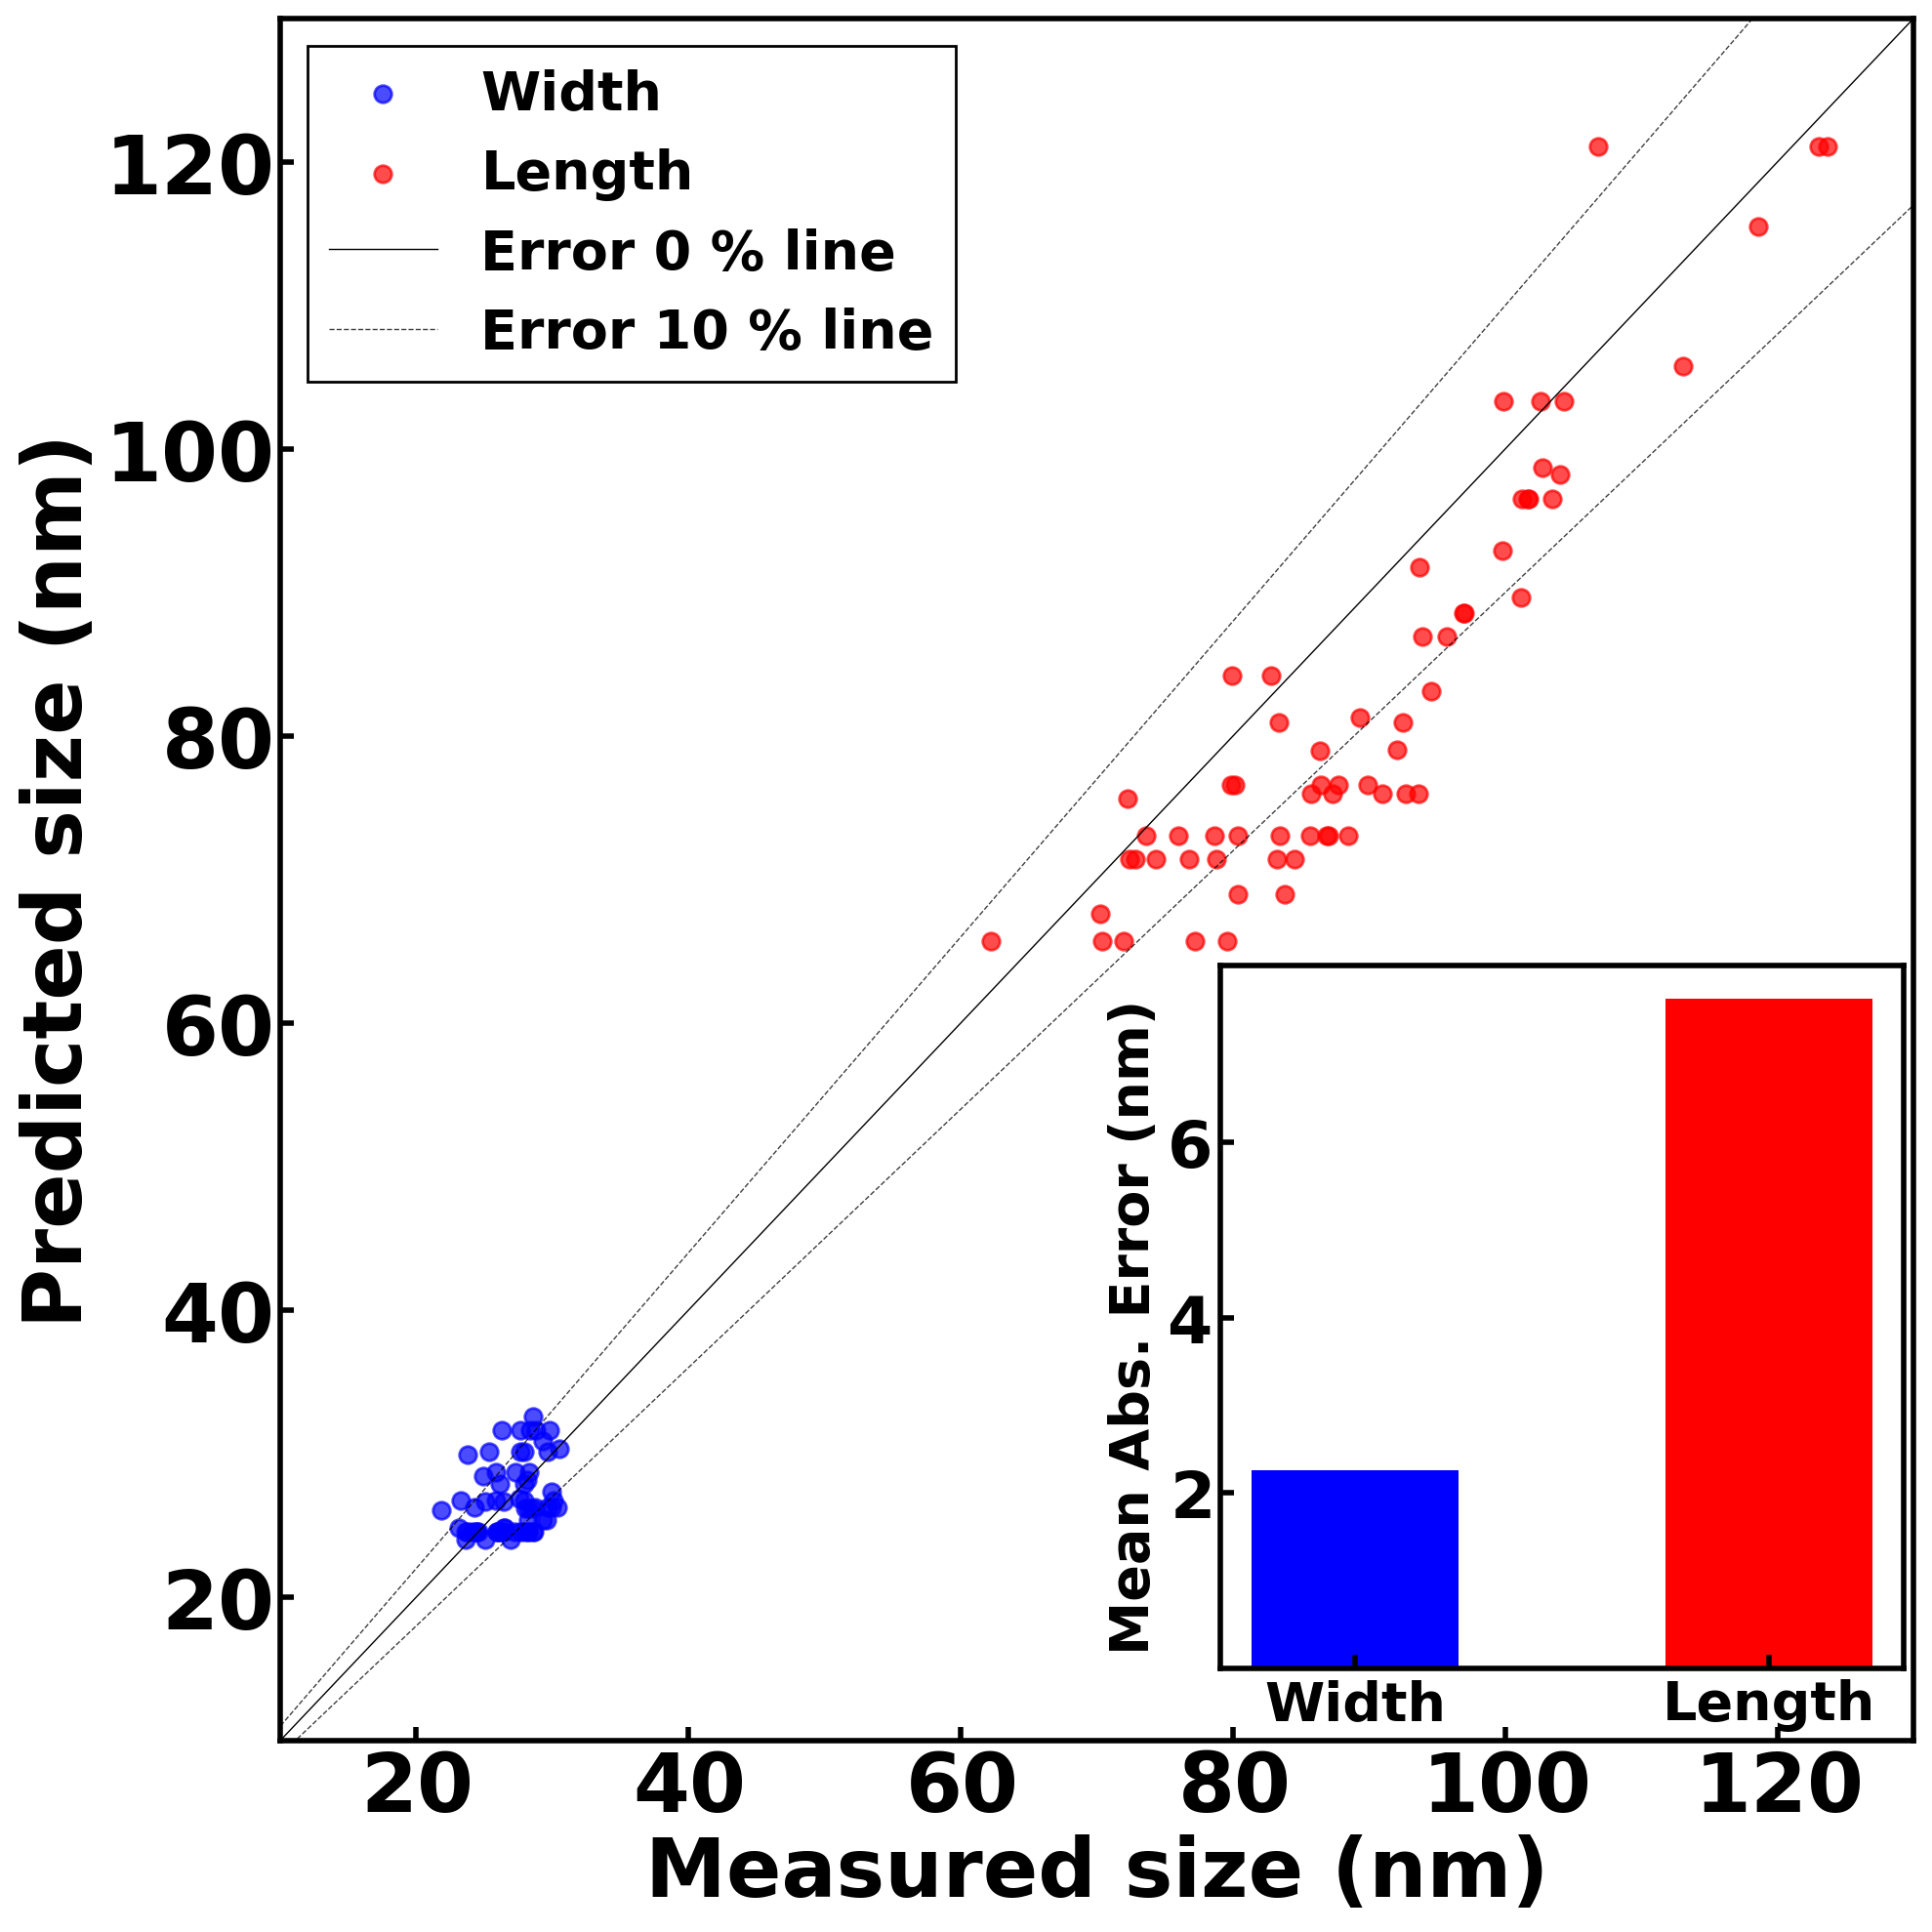

In [12]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=200)

ax.scatter(yw_exp_glass, yw_pred0, s=40, alpha=0.7, c='b', label=f'Width')
ax.scatter(yl_exp_glass, yl_pred0, s=40, alpha=0.7, c='r', label=f'Length')
    
x = np.arange(-1, 181)
ax.plot(x, x, c='k', lw=0.5, label='Error 0 % line')
ax.plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
ax.plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

ax.set_xlabel('Measured size (nm)', fontsize=30)
ax.set_ylabel('Predicted size (nm)', fontsize=30)
ax.tick_params(axis='both', labelsize=30, pad=3)
ax.set_xlim(10, 130)
ax.set_ylim(10, 130)
ax.legend(loc='upper left', fontsize=20)

# Manual inset for A
inset_A = fig.add_axes([0.63, 0.14, 0.35, 0.36])  # Adjust position and size (x, y, width, height)
index = [0, 1]
inset_A.bar(index, [maew0, mael0], width=0.5, color=['b', 'r'])
inset_A.set_xticks(index)
inset_A.set_xticklabels(['Width', 'Length'], fontsize=20)
inset_A.set_ylabel('Mean Abs. Error (nm) ', fontsize=20)
inset_A.set_yticks([2, 4, 6])
# Save the figure
# plt.savefig("AuNR_DA_figureS4.png", dpi=300, bbox_inches='tight')